# 0.1 导入数据集

In [50]:
# 导入所需的package
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具

In [8]:
import os
print("当前路径 -> %s" %os.getcwd()) # 查询当前路径

当前路径 -> C:\Users\Dell


In [59]:
data  = [] #初始化
# load file from system user dictionary!
with open(r"./arxiv-metadata-oai-snapshot.json", 'r') as f: 
    for id, line in enumerate(f):   
         # load id:0~100
        if id>= 100:
            break 
        data.append(json.loads(line)) # add in data
        
data = pd.DataFrame(data) #list to dataframe，方便使用pandas进行分析
data.shape #显示数据大小

(100, 14)

records = 100, num_characters = 14

# 0.2 查看论文类型

In [60]:
'''
count：data的元素个数；
unique：数据的泛类别总数，比如数据的独立类别为A，B，则一条record可能为A or B or (A,B)；
top：一列数据中出现频率最高的元素；
freq：一列数据中出现频率最高的元素的个数；
'''

data["categories"].describe()

count        100
unique        66
top       hep-th
freq           7
Name: categories, dtype: object

## 0.2.1 统计论文数据涉及的独立类别

In [61]:
unique_categories = set([i for l in [x.split(' ') for x in data["categories"]] for i in l])
len(unique_categories)
unique_categories

{'astro-ph',
 'cond-mat.mes-hall',
 'cond-mat.mtrl-sci',
 'cond-mat.other',
 'cond-mat.soft',
 'cond-mat.stat-mech',
 'cond-mat.str-el',
 'cond-mat.supr-con',
 'cs.AI',
 'cs.CE',
 'cs.CG',
 'cs.DS',
 'cs.IT',
 'cs.MS',
 'cs.NA',
 'cs.NE',
 'gr-qc',
 'hep-ex',
 'hep-lat',
 'hep-ph',
 'hep-th',
 'math-ph',
 'math.AG',
 'math.AT',
 'math.CA',
 'math.CO',
 'math.CV',
 'math.DG',
 'math.DS',
 'math.FA',
 'math.GR',
 'math.IT',
 'math.MP',
 'math.NA',
 'math.NT',
 'math.OA',
 'math.PR',
 'math.QA',
 'math.RA',
 'math.RT',
 'nlin.CD',
 'nlin.PS',
 'nlin.SI',
 'nucl-ex',
 'nucl-th',
 'physics.chem-ph',
 'physics.comp-ph',
 'physics.data-an',
 'physics.ed-ph',
 'physics.flu-dyn',
 'physics.gen-ph',
 'physics.optics',
 'physics.plasm-ph',
 'physics.pop-ph',
 'physics.soc-ph',
 'physics.space-ph',
 'q-bio.CB',
 'q-bio.MN',
 'q-bio.PE',
 'q-bio.QM',
 'quant-ph'}

 for record in [cag.split(' ') for cag in data["categories"]] -> 依次取data中每个元素， 每条数据的所有种类存成 record<list>
 for each in record -> 依次取record中每个元素 

# 0.3 分析论文数据

In [62]:
print(data, data.keys()) # 查看data的all key words

                                             abstract  \
0     A fully differential calculation in perturba...   
1     We describe a new algorithm, the $(k,\ell)$-...   
2     The evolution of Earth-Moon system is descri...   
3     We show that a determinant of Stirling cycle...   
4     In this paper we show how to compute the $\L...   
5     We study the two-particle wave function of p...   
6     A rather non-standard quantum representation...   
7     A general formulation was developed to repre...   
8     We discuss the results from the combined IRA...   
9     Partial cubes are isometric subgraphs of hyp...   
10    In this paper we present an algorithm for co...   
11    Recently, Bruinier and Ono classified cusp f...   
12    Serre obtained the p-adic limit of the integ...   
13    In this article we discuss a relation betwee...   
14    The pure spinor formulation of the ten-dimen...   
15    In this work, we evaluate the lifetimes of t...   
16    Results from spectroscopi

In [63]:
data["year"] = pd.to_datetime(data["update_date"]).dt.year #将update_date从例如2019-02-20的str变为datetime格式，并提取处year

del data["update_date"] #删除已提取过的update_date特征

data = data[data["year"] >= 2019] #找出 year 中2019年以后的数据，并将其他数据删除

data.groupby(['categories','year']) #data按categories升序排列，如果同一个categories 相同则使用 year 特征进行排序
data.reset_index(drop=True, inplace=True) #重新编号
data #查看结果

,abstract,authors,authors_parsed,categories,comments,doi,id,journal-ref,license,report-no,submitter,title,versions,year


## 0.3.1 爬取ararXiv Category Taxonomy数据

In [65]:
#爬取
website_url = requests.get('https://arxiv.org/category_taxonomy').text #获取网页的文本数据
soup = BeautifulSoup(website_url,'lxml') #爬取数据，这里使用lxml的解析器，加速
root = soup.find('div',{'id':'category_taxonomy_list'}) #找出 BeautifulSoup 对应的标签入口
tags = root.find_all(["h2","h3","h4","p"], recursive=True) #读取 tags, "h2","h3","h4","p" 分别为爬取节点

#初始化 str 和 list 变量
level_1_name = "" # 节点名称
level_2_name = ""
level_2_code = "" 
level_1_names = []
level_2_codes = []
level_2_names = []
level_3_codes = []
level_3_names = []
level_3_notes = []

#进行
for t in tags:
    if t.name == "h2":
        level_1_name = t.text    
        level_2_code = t.text
        level_2_name = t.text
    elif t.name == "h3":
        raw = t.text
        level_2_code = re.sub(r"(.*)\((.*)\)",r"\2",raw) #正则表达式：substitute "Astrophysics(astro-ph)" to "astro-ph" 
        level_2_name = re.sub(r"(.*)\((.*)\)",r"\1",raw) #正则表达式：substitute "Astrophysics(astro-ph)" to "Astrophysics"
    elif t.name == "h4":
        raw = t.text
        level_3_code = re.sub(r"(.*) \((.*)\)",r"\1",raw)
        level_3_name = re.sub(r"(.*) \((.*)\)",r"\2",raw)
    elif t.name == "p":
        notes = t.text
        level_1_names.append(level_1_name)
        level_2_names.append(level_2_name)
        level_2_codes.append(level_2_code)
        level_3_names.append(level_3_name)
        level_3_codes.append(level_3_code)
        level_3_notes.append(notes)

SSLError: HTTPSConnectionPool(host='arxiv.org', port=443): Max retries exceeded with url: /category_taxonomy (Caused by SSLError(SSLError("bad handshake: SysCallError(-1, 'Unexpected EOF')",),))

PS: 有时候网络不好使...

正则表达式：
re.sub(pattern, repl, string, count=0, flags=0)
pattern：r"(.*)\((.*)\)", 其中(.*)表示匹配任意个字符串，\( 表示匹配"(", \)表示匹配 ")"
repl: r"\2" 表示替换的字符串 repl 为第2个分组的内容
string: raw 

In [66]:
#根据以上信息生成dataframe格式的数据
df_taxonomy = pd.DataFrame({
    'group_name' : level_1_names,  # 类别名
    'archive_name' : level_2_names,
    'archive_id' : level_2_codes,
    'category_name' : level_3_names,
    'categories' : level_3_codes,
    'category_description': level_3_notes
    
})

#按 "group_name"分组，在组内按"archive_name" 升序排列， 组外根据"group_name"升序排列
df_taxonomy.groupby(["group_name","archive_name"])
df_taxonomy

,group_name,archive_name,archive_id,category_name,categories,category_description
0,Computer Science,Computer Science,Computer Science,Artificial Intelligence,cs.AI,"Covers all areas of AI except Vision, Robotics..."
1,Computer Science,Computer Science,Computer Science,Hardware Architecture,cs.AR,Covers systems organization and hardware archi...
2,Computer Science,Computer Science,Computer Science,Computational Complexity,cs.CC,"Covers models of computation, complexity class..."
3,Computer Science,Computer Science,Computer Science,"Computational Engineering, Finance, and Science",cs.CE,Covers applications of computer science to the...
4,Computer Science,Computer Science,Computer Science,Computational Geometry,cs.CG,Roughly includes material in ACM Subject Class...
5,Computer Science,Computer Science,Computer Science,Computation and Language,cs.CL,Covers natural language processing. Roughly in...
6,Computer Science,Computer Science,Computer Science,Cryptography and Security,cs.CR,Covers all areas of cryptography and security ...
7,Computer Science,Computer Science,Computer Science,Computer Vision and Pattern Recognition,cs.CV,"Covers image processing, computer vision, patt..."
8,Computer Science,Computer Science,Computer Science,Computers and Society,cs.CY,"Covers impact of computers on society, compute..."
9,Computer Science,Computer Science,Computer Science,Databases,cs.DB,"Covers database management, datamining, and da..."


## 0.3.2 查看所有大类的paper数量分布

In [68]:
_df = data.merge(df_taxonomy, on="categories", how="left").drop_duplicates(["id","group_name"]).groupby("group_name").agg({"id":"count"}).sort_values(by="id",ascending=False).reset_index()

_df # 表格

,group_name,id


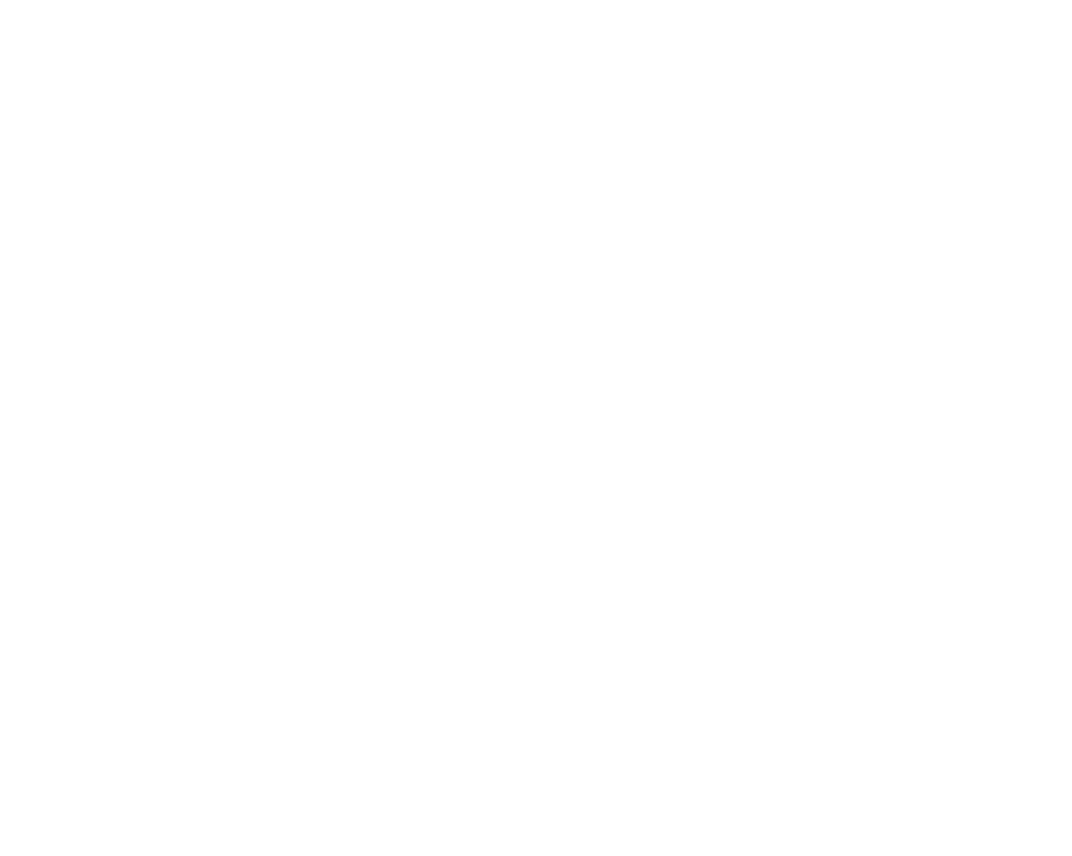

In [70]:
fig = plt.figure(figsize=(15,12))
explode = (0, 0, 0, 0.2, 0.3, 0.3, 0.2, 0.1) 
plt.pie(_df["id"],  labels=_df["group_name"], autopct='%1.2f%%', startangle=160) # 饼图展示
plt.tight_layout()
plt.show() 

## 0.3.2 统计在计算机各个子领域2019年后的paper数量

In [71]:
group_name="Computer Science"
cats = data.merge(df_taxonomy, on="categories").query("group_name == @group_name")
cats.groupby(["year","category_name"]).count().reset_index().pivot(index="category_name", columns="year",values="id") 

year
category_name
